## convolutional neural networks model for kaggle's original dogs vs. cats 
### uses keras 2.0.4, python 2.7, modified fast.ai's vgg and utils scripts

job run on floydhub

In [1]:
# to show plots in the notebook
%matplotlib inline

In [2]:
# define path to data
path = '/input/dogscats/'

In [3]:
# python libraries
from __future__ import division,print_function # for some python 3 functionality

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision = 4, linewidth = 100)
from matplotlib import pyplot as plt

In [4]:
# fastai's convenience functions
import utils; reload(utils)
from utils import plots

Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
Using Theano backend.


### using a pretrained model: vgg16

In [5]:
# choose smaller batch sizes for older GPUs
batch_size = 64

In [6]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [7]:
vgg = Vgg16()
# grab a few images at a time for training and validation
# nb: previously divided into subdirectories named by category
batches = vgg.get_batches(path+'train', batch_size = batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size = batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, epochs = 1)

/usr/local/lib/python2.7/site-packages/keras/layers/core.py:640: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
359/359 [==============================] - 449s - loss: 0.1345 - acc: 0.9647   


### using vgg16 for image recognition

In [9]:
# vgg16 object defined above
# grab batches from training folder
batches = vgg.get_batches(path+'train', batch_size = 4)

Found 23000 images belonging to 2 classes.


In [11]:
imgs,labels = next(batches)

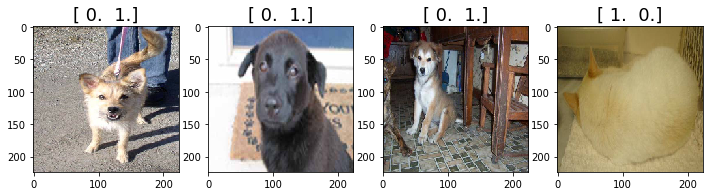

In [12]:
plots(imgs, titles = labels)

In [13]:
# pass images through vgg's predict() function to get probabilities, category indices, category names
vgg.predict(imgs, True)

(array([ 0.5371,  0.4522,  0.1162,  0.2978], dtype=float32),
 array([186, 208, 207, 258]),
 [u'Norwich_terrier', u'Labrador_retriever', u'golden_retriever', u'Samoyed'])

### fine tune a dogs vs. cats model

In [14]:
# changes the model to identify dog or cat, not specific categories of such
batch_size = 64

In [15]:
batches = vgg.get_batches(path+'train', batch_size = batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size = batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [16]:
vgg.finetune(batches)

In [18]:
# fit() function fits the model parameters using training data
# reports accuracy on validation set after every epoch (i.e. each pass through training set)
vgg.fit(batches, val_batches, epochs = 1)

Epoch 1/1
359/359 [==============================] - 448s - loss: 0.1254 - acc: 0.9675   


### create vgg model from scratch using keras 2.0.4

In [19]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K 
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [20]:
# import vgg mappings
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE = 'imagenet_class_index.json'
# get_file() is keras function that caches files
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir = 'models')
with open(fpath) as f: class_dict = json.load(f)
# convert dictionary with string indices into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [21]:
# sample of categories just imported
classes[ :5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

### model creation: basic architecture and loading weights

In [22]:
# defined convolutional block (for finding patterns in images)
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides = (2,2)))

In [23]:
# fully connected block for combining patterns across an image
def FCBlock(model):
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))

In [24]:
# preprocess data to comport with vgg model specs: data for each channel has mean 0
# mean of each channel as provided by vgg creators
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr -> python default rgb

In [25]:
# define vgg model architecture
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation = 'softmax'))
    return model

In [26]:
# create the model like any python object
model = VGG_16()

/usr/local/lib/python2.7/site-packages/keras/layers/core.py:640: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [27]:
# get weights vgg creators trained (part of the model that is learned from the data)
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir = 'models')
model.load_weights(fpath)

In [32]:
# grab some imagenet images
batch_size = 4

In [33]:
# wrapper to define defaults for image resize, labels, randomization, and number of images in batch
def get_batches(dirname, gen = image.ImageDataGenerator(), shuffle = True, 
                batch_size = batch_size, class_mode = 'categorical'):
    return gen.flow_from_directory(path+dirname, target_size = (224,224), 
                class_mode = class_mode, shuffle = shuffle, batch_size = batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


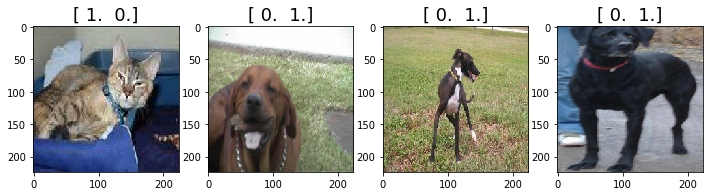

In [34]:
# same steps as above to get predictions
batches = get_batches('train', batch_size = batch_size)
val_batches = get_batches('valid', batch_size = batch_size)
imgs,labels = next(batches)

# shows the predictions
plots(imgs, titles = labels)

In [35]:
# vgg model returns 1000 probabilites assigning imagenet category for each image
# find index with largest probability (np.argmax()) to find the predicted label
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis = 1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [36]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  3.0090e-07   1.0694e-06   6.9109e-06   4.0882e-06   3.1542e-06]

Predictions prob/class: 
  0.5630/lynx
  0.8948/redbone
  0.5236/Italian_greyhound
  0.3325/Labrador_retriever
